In [81]:
import glob
import pandas as pd
import mne
import matplotlib
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.io import loadmat

# V1

(2676, 29)


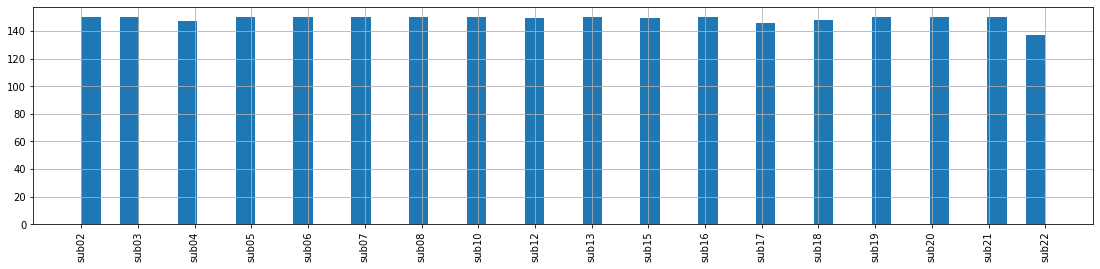

In [82]:
# df = pd.read_excel('139-new-ld-v3.xlsx')
df = pd.read_excel('151-pburg-v1.xlsx')
df['sub'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')
print(df.shape)

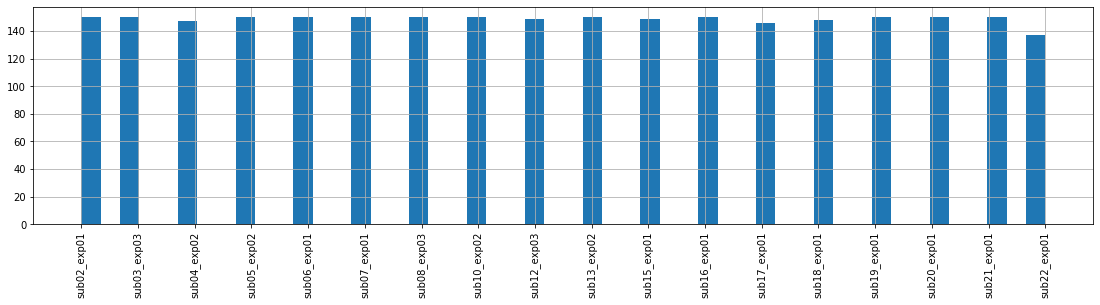

In [69]:
# df = df[~df['sub'].isin(['sub05', 'sub09', 'sub11', 'sub10'])]
# df = df[~df['sub'].isin(['sub05', 'sub09', 'sub11', 'sub10', 'sub03', 'sub06', 'sub12'])]
df['sub_exp'] = df['sub'] + "_" + df['exp']
df['sub_exp_run'] = df['sub_exp'] + "_" + df['run']
df = df[~df['sub_exp'].isin(['sub04_exp01', 'sub14_exp01'])]
# df = df[~df['sub_exp'].isin(['sub03_exp01'])]
# df = df[df['mep_latency'] < 0.2]
# df = df[df['mep_latency'] > 0]
# df.to_excel('140-ld-v3.xlsx')
# df.to_excel('148-csd-avg-v2.xlsx')
df['sub_exp'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')

In [83]:
df['mep_size_log'] = np.log(df['mep_size'])
df['mep_duration_log'] = np.log(df['mep_duration'])
df['mep_latency_log'] = np.log(df['mep_latency'])
df['mep_area_log'] = np.log(df['mep_area'])

In [84]:
df.groupby('sub').first()[['exp', 'name']]

,exp,name
sub,,
sub02,exp01,David Brown
sub03,exp03,Sarah Brunet
sub04,exp02,Lynette Gallaty
sub05,exp02,Mana Higashihara
sub06,exp01,Tim Howells
sub07,exp01,Merolene Pirsarkiewicz
sub08,exp03,Steve Vucic
sub10,exp02,Nimeshan Geevasinga
sub12,exp03,Marshall Owen


# Tertiles/quartiles

In [85]:
df3 = []
subs = df['sub'].unique()
for sub in tqdm(subs):
    df2 = df[df['sub'] == sub]
    for target in ['mep_size', 'mep_latency', 'mep_duration', 'mep_area']:
        perc = np.percentile(df2[target + '_log'], [100/3, 100*2/3])
        df2[target + '_tertile_class'] = df2.apply(lambda row: 1 if row[target + '_log'] < perc[0] else (3 if row[target + '_log'] > perc[1] else 2) , axis=1)
    for idx, row in df2.iterrows():
        df3.append(row)
df3 = pd.DataFrame(df3)

  0%|          | 0/18 [00:00<?, ?it/s]/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


In [86]:
df3.shape

(2676, 37)

In [87]:
df3.columns.values

array(['Unnamed: 0', 'beta_phase', 'beta_power', 'cmap', 'exp',
       'gamma_phase', 'gamma_power', 'high_beta_phase', 'high_beta_power',
       'high_gamma_phase', 'high_gamma_power', 'low_beta_phase',
       'low_beta_power', 'low_gamma_phase', 'low_gamma_power', 'mep_area',
       'mep_duration', 'mep_latency', 'mep_size', 'mu_phase', 'mu_power',
       'rejected', 'run', 'sub', 'theta_phase', 'theta_power',
       'trial_num', 'name', 'sub_exp', 'mep_size_log', 'mep_duration_log',
       'mep_latency_log', 'mep_area_log', 'mep_size_tertile_class',
       'mep_latency_tertile_class', 'mep_duration_tertile_class',
       'mep_area_tertile_class'], dtype=object)

In [88]:
df3.to_excel('151-pburg-v2-tertile.xlsx')

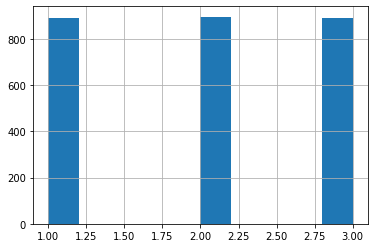

In [75]:
df3['mep_duration_tertile_class'].hist()

# Quartiles

In [ ]:
df3 = []
subs = df['sub'].unique()
for sub in tqdm(subs):
    df2 = df[df['sub'] == sub]
    for target in ['mep_size', 'mep_latency', 'mep_duration', 'mep_area']:
        perc = np.percentile(df2[target + '_log'], [.25, .5, .75])
        df2[target + '_tertile_class'] = df2.apply(lambda row: 1 if row[target + '_log'] < perc[0] else (3 if row[target + '_log'] > perc[1] else 2) , axis=1)
    for idx, row in df2.iterrows():
        df3.append(row)
df3 = pd.DataFrame(df3)